In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [20]:
init_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                   names=['sepal_len','sepal_width','petal_len','petal_width','flower'])
init_data.head()

,sepal_len,sepal_width,petal_len,petal_width,flower
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [21]:
init_data['flower'].value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: flower, dtype: int64

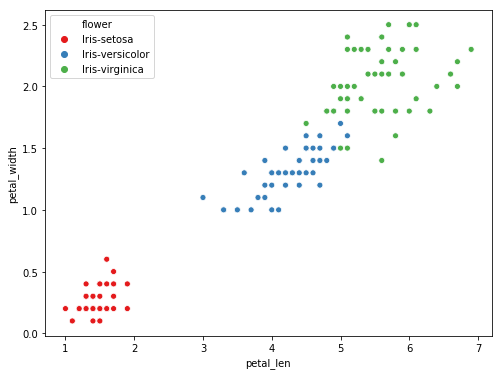

In [4]:
#for flower, group in data.groupby('flower'):
plt.figure(figsize=(8,6))
sns.scatterplot(x=init_data['petal_len'], y=init_data['petal_width'], alpha=1, hue=init_data['flower'], palette='Set1')
plt.show()

## How K-Means is implemented
1) Select initial random centroids (rows in the data, they must all be different)  
2) Calculate each data point's distance from every centroid (comparing the data points features to that of the centroids)  
3) Assign a centroid to each data point, based on which centroid is closest to it (total distance of all its features)  
4) Take an average of the data points assigned to a given centroid and use that to create a new centroid  
   *the features are used to create the average, so the new centroid is a hybrid of all the data points assigned to it  
Repeat step 2-4 until no improvement is made

### Functionality

In [29]:
def normalise_data(data, features):
    scaler = StandardScaler(copy=False).fit(data[features])
    data[features] = scaler.transform(data[features])
    return data, scaler

def unnormalise_data(init_data, features, centroids, scaler):
    data = init_data.copy()
    centroids = pd.DataFrame(centroids)
    centroids = (centroids * scaler.scale_) + scaler.mean_
    data[features] = (data[features] * scaler.scale_) + scaler.mean_
    return data, centroids

def find_first_centroids(data, features, num_centroids):
    data = data.drop_duplicates(features)
    centroids_idx = np.random.choice(data.index, num_centroids, replace=False)
    centroids = data.loc[centroids_idx].reset_index(drop=True)[features].to_dict('records')
    return centroids

def assign_centroid(row, centroids, features):   
    cent_distances = []
    for centroid in centroids:
        idx = centroids.index(centroid)
        dist = 0
        for feature in features:
            dist += (row[feature] - centroid[feature]) ** 2
        cent_distances.append(dist**0.5)
    return np.argmin(cent_distances), min(cent_distances)

def find_new_centroids(data, centroids, features):
    new_centroids = []
    for idx in range(len(centroids)):
        average_features = data[data['centroid_assigned'] == idx][features].mean(axis='rows')
        new_centroids.append(average_features.to_dict())
    return new_centroids

def plot_centroids(init_data, centroids, scaler, features, hue='flower'):
    data, centroids = unnormalise_data(init_data, features, centroids, scaler)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=data['petal_len'], y=data['petal_width'], hue=data[hue], palette='Set1')
    sns.scatterplot(x=centroids['petal_len'], y=centroids['petal_width'], alpha= 0.7, marker='+', s=1000,
                    linewidth='3', palette='Set1')
    plt.show()

def fit_centroids(data, features, num_centroids, scaler, plot=False):
    centroids = find_first_centroids(data, features, num_centroids)
    prev_centroids = []
    iteration = 0
    while True:
        iteration += 1          
        data[['centroid_assigned','distance']] = data.apply(assign_centroid, args=(centroids, features), axis='columns',
                                                            result_type='expand')
        data['centroid_assigned'] = data['centroid_assigned'].astype(int)
        if plot:
            assert len(features) == 2
            print('centroid iteration', iteration)
            plot_centroids(data, centroids, scaler, features, hue='centroid_assigned')
        centroids = find_new_centroids(data, centroids, features)
        if centroids == prev_centroids:
            break
        else:
            prev_centroids = centroids.copy()        
    data, centroids = unnormalise_data(data, features, centroids, scaler)
    return data, centroids

def k_means(data, features, n_clusters, max_iter, plot_result=False):
    data, scaler = normalise_data(data, features)
    results = []
    for _ in range(max_iter):
        output, centroids = fit_centroids(data, features, n_clusters, scaler, plot=False)
        varience = output['distance'].sum()
        results.append({'variance':varience,'centroids':centroids})
    sorted_results = pd.DataFrame(results).sort_values('variance')
    best_centroids = sorted_results.iloc[0,1:].to_dict()['centroids']
    if plot_result:
        assert len(features) == 2
        plot_centroids(output, best_centroids, scaler, features, hue='centroid_assigned')   
    output, best_centroids = unnormalise_data(output, features, best_centroids, scaler)
    return output, best_centroids

### A simple two feature example
Plot centroid location at each iteration of a single K-Means

centroid iteration 1


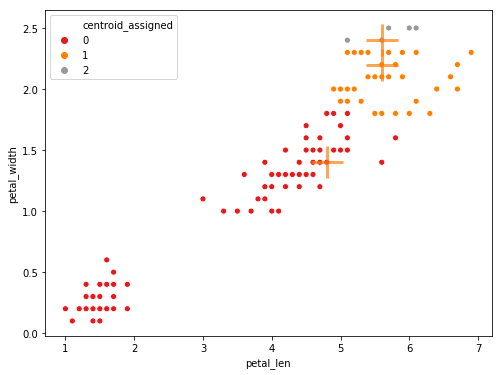

centroid iteration 2


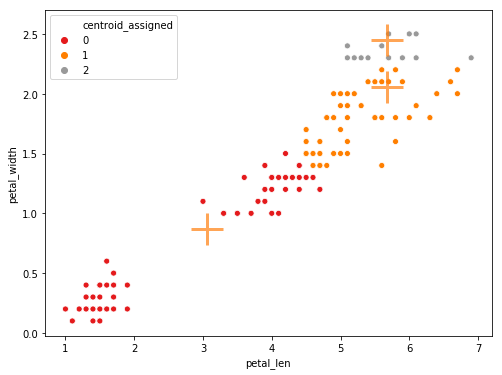

centroid iteration 3


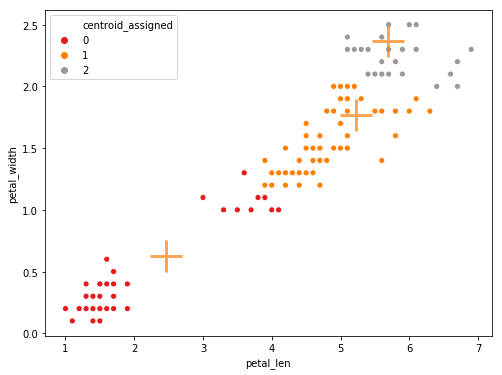

centroid iteration 4


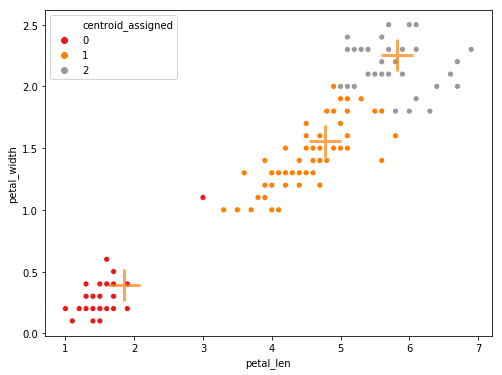

centroid iteration 5


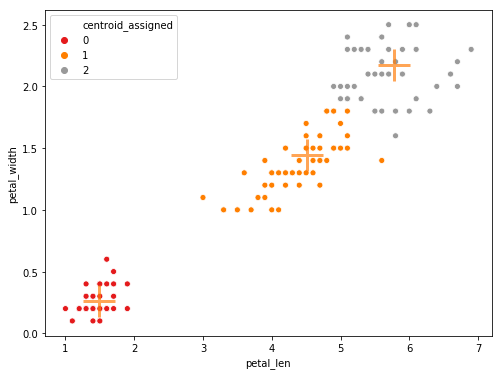

centroid iteration 6


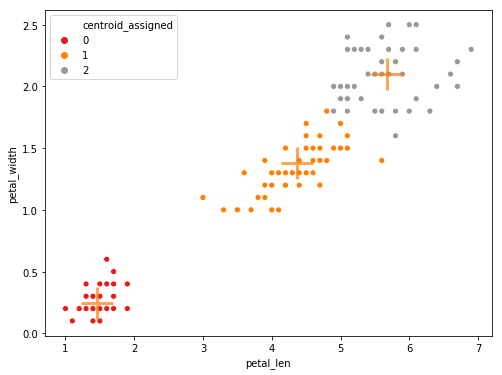

centroid iteration 7


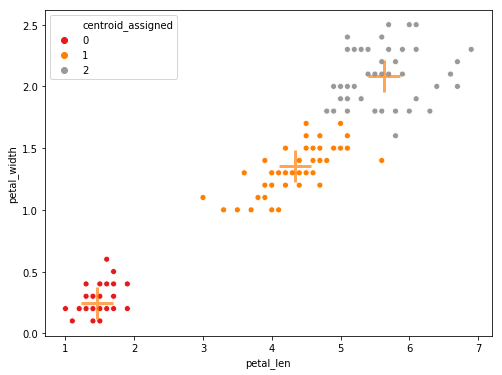

centroid iteration 8


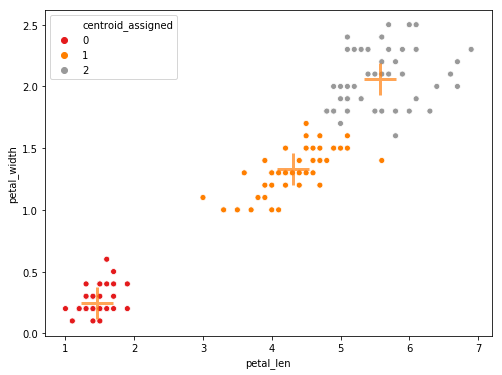

centroid iteration 9


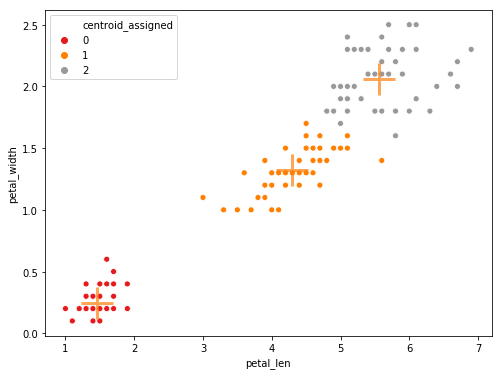

,petal_len,petal_width,flower,centroid_assigned,distance
0,1.4,0.2,Iris-setosa,0,0.068344
1,1.4,0.2,Iris-setosa,0,0.068344
2,1.3,0.2,Iris-setosa,0,0.109744
3,1.5,0.2,Iris-setosa,0,0.061364
4,1.4,0.2,Iris-setosa,0,0.068344
...,...,...,...,...,...
145,5.2,2.3,Iris-virginica,2,0.382326
146,5.0,1.9,Iris-virginica,2,0.382149
147,5.2,2.0,Iris-virginica,2,0.221234
148,5.4,2.3,Iris-virginica,2,0.334186


In [13]:
data = init_data[['petal_len', 'petal_width', 'flower']]
features = ['petal_len', 'petal_width']
num_centroids = 3
data, scaler = normalise_data(data, features)
output, centroids = fit_centroids(data, features, num_centroids, scaler, plot=True)
output

### K-means, two features
Compute mean centroid variation in each model iteration to find best centroids

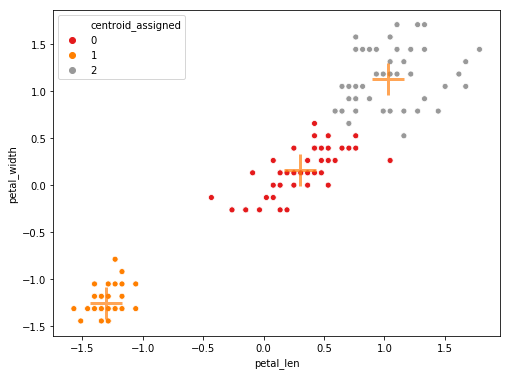

,petal_len,petal_width
centroids,,
0,0.305646,0.166094
1,-1.304878,-1.255129
2,1.028132,1.127490


In [32]:
features = ['petal_len', 'petal_width']
max_iter = 10
n_clusters = 3
output, best_centroids = k_means(data, features, n_clusters, max_iter, plot_result=True)
pd.DataFrame(best_centroids).rename_axis('centroids')

###  K-means, four features

In [33]:
features = ['petal_len', 'petal_width', 'sepal_len', 'sepal_width']
full_data = init_data[features]
max_iter = 10
n_clusters = 3
output, best_centroids = k_means(full_data, features, n_clusters, max_iter, plot_result=False)
pd.DataFrame(best_centroids).rename_axis('centroids')

,petal_len,petal_width,sepal_len,sepal_width
centroids,,,,
0,13.365063,2.690064,11.393889,4.386028
1,11.366997,2.248002,10.613238,4.200511
2,6.333153,1.384256,9.974792,4.531077


###  K-means, 4 centroids (too many)

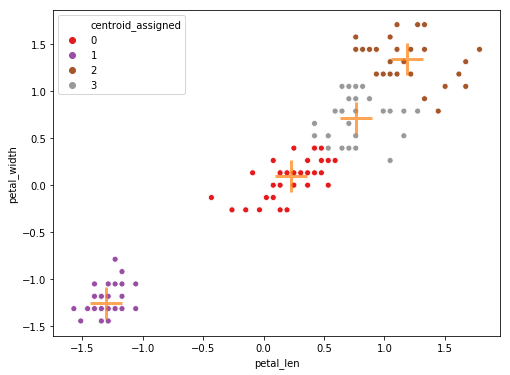

,petal_len,petal_width
centroids,,
0,1.190304,1.345699
1,-1.304878,-1.255129
2,0.764593,0.718493
3,0.223888,0.098793


In [34]:
features = ['petal_len', 'petal_width']
max_iter = 10
n_clusters = 4
output, best_centroids = k_means(data, features, n_clusters, max_iter, plot_result=True)
pd.DataFrame(best_centroids).rename_axis('centroids')